# Model training.

[Dataset](https://github.com/imesluh/vocalfolds)


In [1]:
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [2]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from Uformer import model
from losses import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
import gc

In [3]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 2060 SUPER')

In [4]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)

In [5]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 7
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 1e-3
WEIGHT_DECAY = 1e-5
NUM_EPOCHS = 100
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

## Data preparation.

In [6]:
IMAGE_DATASET_PATH = glob('../../vocalfolds/img/*/*/*.png')
MASK_DATASET_PATH  = glob('../../vocalfolds/annot/*/*/*.png')

N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 536


In [7]:
# https://gist.github.com/IdeaKing/11cf5e146d23c5bb219ba3508cca89ec
def resize_with_pad(image: np.array, 
                    new_shape, 
                    padding_color = (0, 0, 0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [8]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[0],[1],[2],[3],[4],[5],[6]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (0, 0, 0))
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (NUM_CLASSES, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [9]:
uformer = model.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=NUM_CLASSES, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
trainImages, testImages, trainMasks, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

c:\Users\alexg\miniconda3\envs\pytorch-gpu\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
# define transformations
from torch.utils.data import DataLoader

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
num_workers = 4
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainLoader = DataLoader(
	trainDS, 
	shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)

[INFO] found 428 examples in the training set...
[INFO] found 108 examples in the test set...


In [11]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = torch.nn.CrossEntropyLoss().cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-5)

scaler = torch.cuda.amp.GradScaler(enabled=True)

iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE + 1
testSteps = len(testDS) // BATCH_SIZE + 1
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_IoU": [], "test_IoU": [],"train_DC": [], "test_DC": []}

In [12]:
# Timing utilities
start_time = None

def start_timer():
    global start_time
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated()
    torch.cuda.synchronize()
    start_time = time.time()

def end_timer_and_print(local_msg):
    torch.cuda.synchronize()
    end_time = time.time()
    print("\n" + local_msg)
    print("Total execution time = {:.3f} sec".format(end_time - start_time))
    print("Max memory used by tensors = {} bytes".format(torch.cuda.max_memory_allocated()))

In [13]:
bestIoU = 0
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
start_timer()
for e in range(NUM_EPOCHS):
	# set the model in training mode
	uformer.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	totalTrainIoU = 0
	totalTestIoU = 0
	totalTrainDC = 0
	totalTestDC = 0
	# loop over the training set
	for i, (x, y) in enumerate(tqdm(trainLoader)):
		# send the input to the device
		x, y = x.to(DEVICE), y.to(DEVICE)
		# perform a forward pass and calculate the training loss
		with torch.autocast(device_type=DEVICE, dtype=torch.float16):
			pred = uformer(x)
			assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
			pred = softmax(pred)
			loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		scaler.scale(loss).backward()
		scaler.step(opt)
		opt.zero_grad()
		scaler.update()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		totalTrainIoU += iouMetric(pred, y)
		totalTrainDC += gdlMetric(pred, y)
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		uformer.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = uformer(x)
			assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
			pred = softmax(pred)
			totalTestLoss += lossFunc(pred, y)
			totalTestIoU += iouMetric(pred, y)
			totalTestDC += gdlMetric(pred, y)
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	avgTrainIoU = totalTrainIoU / trainSteps
	avgTestIoU = totalTestIoU / testSteps
	avgTrainDC = totalTrainDC / trainSteps
	avgTestDC = totalTestDC / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	H["train_IoU"].append(avgTrainIoU.cpu().detach().numpy())
	H["test_IoU"].append(avgTestIoU.cpu().detach().numpy())
	H["train_DC"].append(avgTrainDC.cpu().detach().numpy())
	H["test_DC"].append(avgTestDC.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}, " + 
       f"Train IoU: {avgTrainIoU:.4f}, Test IoU: {avgTestIoU:.4f}, Train Dice: {avgTrainDC:.4f}, Test Dice: {avgTestDC:.4f}")

	if avgTestIoU > bestIoU:
		bestIoU = avgTestIoU
		torch.save(uformer.state_dict(), '../models/vf_uformerAMP.pth')
		print('Best IoU improved. Model saved.')
		
# display the total time needed to perform the training
end_timer_and_print("Mixed precision:")
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
print(f'Best IoU is: {bestIoU:.5f}')

[INFO] training the network...


c:\Users\alexg\miniconda3\envs\pytorch-gpu\lib\site-packages\torch\cuda\memory.py:303: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
100%|██████████| 14/14 [00:07<00:00,  1.88it/s]


[INFO] EPOCH: 1/100
Train loss: 1.832010, Test loss: 1.8134, Train IoU: 0.2085, Test IoU: 0.2063, Train Dice: 0.2977, Test Dice: 0.3395
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 2/100
Train loss: 1.794205, Test loss: 1.7849, Train IoU: 0.2221, Test IoU: 0.2245, Train Dice: 0.3559, Test Dice: 0.3474
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 3/100
Train loss: 1.762304, Test loss: 1.7684, Train IoU: 0.2428, Test IoU: 0.2403, Train Dice: 0.3793, Test Dice: 0.3768
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 4/100
Train loss: 1.739683, Test loss: 1.7332, Train IoU: 0.2669, Test IoU: 0.2710, Train Dice: 0.4037, Test Dice: 0.4061
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[INFO] EPOCH: 5/100
Train loss: 1.679757, Test loss: 1.6419, Train IoU: 0.3184, Test IoU: 0.3518, Train Dice: 0.4673, Test Dice: 0.5158
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.79it/s]


[INFO] EPOCH: 6/100
Train loss: 1.589914, Test loss: 1.5931, Train IoU: 0.4019, Test IoU: 0.3995, Train Dice: 0.5685, Test Dice: 0.5661
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[INFO] EPOCH: 7/100
Train loss: 1.543838, Test loss: 1.5151, Train IoU: 0.4500, Test IoU: 0.4811, Train Dice: 0.6135, Test Dice: 0.6432
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


[INFO] EPOCH: 8/100
Train loss: 1.495000, Test loss: 1.4965, Train IoU: 0.5029, Test IoU: 0.5009, Train Dice: 0.6632, Test Dice: 0.6625
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


[INFO] EPOCH: 9/100
Train loss: 1.483805, Test loss: 1.4809, Train IoU: 0.5152, Test IoU: 0.5198, Train Dice: 0.6757, Test Dice: 0.6776
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 10/100
Train loss: 1.458459, Test loss: 1.4365, Train IoU: 0.5463, Test IoU: 0.5737, Train Dice: 0.7006, Test Dice: 0.7240
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


[INFO] EPOCH: 11/100
Train loss: 1.437470, Test loss: 1.4454, Train IoU: 0.5710, Test IoU: 0.5615, Train Dice: 0.7225, Test Dice: 0.7150


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 12/100
Train loss: 1.428891, Test loss: 1.4310, Train IoU: 0.5820, Test IoU: 0.5793, Train Dice: 0.7315, Test Dice: 0.7299
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 13/100
Train loss: 1.421916, Test loss: 1.4357, Train IoU: 0.5915, Test IoU: 0.5732, Train Dice: 0.7387, Test Dice: 0.7248


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 14/100
Train loss: 1.430821, Test loss: 1.4196, Train IoU: 0.5793, Test IoU: 0.5939, Train Dice: 0.7302, Test Dice: 0.7419
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 15/100
Train loss: 1.417514, Test loss: 1.4108, Train IoU: 0.5967, Test IoU: 0.6053, Train Dice: 0.7441, Test Dice: 0.7507
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 16/100
Train loss: 1.400214, Test loss: 1.3960, Train IoU: 0.6197, Test IoU: 0.6250, Train Dice: 0.7610, Test Dice: 0.7656
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 17/100
Train loss: 1.385904, Test loss: 1.3944, Train IoU: 0.6384, Test IoU: 0.6280, Train Dice: 0.7757, Test Dice: 0.7671
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 18/100
Train loss: 1.376526, Test loss: 1.3838, Train IoU: 0.6517, Test IoU: 0.6422, Train Dice: 0.7852, Test Dice: 0.7781
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 19/100
Train loss: 1.368428, Test loss: 1.3801, Train IoU: 0.6627, Test IoU: 0.6472, Train Dice: 0.7936, Test Dice: 0.7819
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 20/100
Train loss: 1.363395, Test loss: 1.3764, Train IoU: 0.6697, Test IoU: 0.6525, Train Dice: 0.7988, Test Dice: 0.7858
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 21/100
Train loss: 1.367896, Test loss: 1.3904, Train IoU: 0.6627, Test IoU: 0.6327, Train Dice: 0.7946, Test Dice: 0.7720


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[INFO] EPOCH: 22/100
Train loss: 1.364226, Test loss: 1.3744, Train IoU: 0.6678, Test IoU: 0.6541, Train Dice: 0.7984, Test Dice: 0.7884
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


[INFO] EPOCH: 23/100
Train loss: 1.355328, Test loss: 1.3765, Train IoU: 0.6809, Test IoU: 0.6525, Train Dice: 0.8074, Test Dice: 0.7860


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 24/100
Train loss: 1.353776, Test loss: 1.3754, Train IoU: 0.6828, Test IoU: 0.6530, Train Dice: 0.8091, Test Dice: 0.7872


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 25/100
Train loss: 1.351949, Test loss: 1.3682, Train IoU: 0.6854, Test IoU: 0.6632, Train Dice: 0.8109, Test Dice: 0.7946
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[INFO] EPOCH: 26/100
Train loss: 1.347373, Test loss: 1.3694, Train IoU: 0.6918, Test IoU: 0.6618, Train Dice: 0.8156, Test Dice: 0.7933


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[INFO] EPOCH: 27/100
Train loss: 1.344328, Test loss: 1.3688, Train IoU: 0.6965, Test IoU: 0.6622, Train Dice: 0.8186, Test Dice: 0.7941


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[INFO] EPOCH: 28/100
Train loss: 1.349414, Test loss: 1.3665, Train IoU: 0.6891, Test IoU: 0.6656, Train Dice: 0.8134, Test Dice: 0.7964
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


[INFO] EPOCH: 29/100
Train loss: 1.346537, Test loss: 1.3629, Train IoU: 0.6933, Test IoU: 0.6701, Train Dice: 0.8166, Test Dice: 0.8003
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[INFO] EPOCH: 30/100
Train loss: 1.342636, Test loss: 1.3705, Train IoU: 0.6990, Test IoU: 0.6597, Train Dice: 0.8204, Test Dice: 0.7924


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 31/100
Train loss: 1.337116, Test loss: 1.3568, Train IoU: 0.7070, Test IoU: 0.6799, Train Dice: 0.8261, Test Dice: 0.8063
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 32/100
Train loss: 1.336032, Test loss: 1.3545, Train IoU: 0.7090, Test IoU: 0.6831, Train Dice: 0.8272, Test Dice: 0.8087
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


[INFO] EPOCH: 33/100
Train loss: 1.338218, Test loss: 1.3554, Train IoU: 0.7050, Test IoU: 0.6812, Train Dice: 0.8250, Test Dice: 0.8080


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 34/100
Train loss: 1.333060, Test loss: 1.3494, Train IoU: 0.7132, Test IoU: 0.6899, Train Dice: 0.8304, Test Dice: 0.8140
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 35/100
Train loss: 1.333877, Test loss: 1.3633, Train IoU: 0.7116, Test IoU: 0.6706, Train Dice: 0.8295, Test Dice: 0.7998


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 36/100
Train loss: 1.332932, Test loss: 1.3503, Train IoU: 0.7132, Test IoU: 0.6886, Train Dice: 0.8305, Test Dice: 0.8131


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[INFO] EPOCH: 37/100
Train loss: 1.327327, Test loss: 1.3470, Train IoU: 0.7212, Test IoU: 0.6934, Train Dice: 0.8362, Test Dice: 0.8163
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


[INFO] EPOCH: 38/100
Train loss: 1.324041, Test loss: 1.3479, Train IoU: 0.7268, Test IoU: 0.6919, Train Dice: 0.8396, Test Dice: 0.8156


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 39/100
Train loss: 1.325109, Test loss: 1.3427, Train IoU: 0.7253, Test IoU: 0.6993, Train Dice: 0.8385, Test Dice: 0.8209
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


[INFO] EPOCH: 40/100
Train loss: 1.321668, Test loss: 1.3391, Train IoU: 0.7302, Test IoU: 0.7050, Train Dice: 0.8421, Test Dice: 0.8244
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[INFO] EPOCH: 41/100
Train loss: 1.319965, Test loss: 1.3397, Train IoU: 0.7328, Test IoU: 0.7039, Train Dice: 0.8437, Test Dice: 0.8239


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 42/100
Train loss: 1.319212, Test loss: 1.3387, Train IoU: 0.7342, Test IoU: 0.7053, Train Dice: 0.8446, Test Dice: 0.8249
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


[INFO] EPOCH: 43/100
Train loss: 1.316707, Test loss: 1.3427, Train IoU: 0.7375, Test IoU: 0.6993, Train Dice: 0.8471, Test Dice: 0.8209


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 44/100
Train loss: 1.319509, Test loss: 1.3423, Train IoU: 0.7330, Test IoU: 0.7001, Train Dice: 0.8443, Test Dice: 0.8215


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 45/100
Train loss: 1.318347, Test loss: 1.3396, Train IoU: 0.7348, Test IoU: 0.7042, Train Dice: 0.8455, Test Dice: 0.8242


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 46/100
Train loss: 1.316749, Test loss: 1.3365, Train IoU: 0.7375, Test IoU: 0.7089, Train Dice: 0.8471, Test Dice: 0.8272
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


[INFO] EPOCH: 47/100
Train loss: 1.315411, Test loss: 1.3385, Train IoU: 0.7394, Test IoU: 0.7056, Train Dice: 0.8485, Test Dice: 0.8253


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


[INFO] EPOCH: 48/100
Train loss: 1.315393, Test loss: 1.3382, Train IoU: 0.7396, Test IoU: 0.7066, Train Dice: 0.8485, Test Dice: 0.8257


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 49/100
Train loss: 1.316890, Test loss: 1.3377, Train IoU: 0.7371, Test IoU: 0.7067, Train Dice: 0.8470, Test Dice: 0.8262


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 50/100
Train loss: 1.316214, Test loss: 1.3359, Train IoU: 0.7382, Test IoU: 0.7092, Train Dice: 0.8477, Test Dice: 0.8279
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


[INFO] EPOCH: 51/100
Train loss: 1.314201, Test loss: 1.3343, Train IoU: 0.7415, Test IoU: 0.7116, Train Dice: 0.8498, Test Dice: 0.8295
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 52/100
Train loss: 1.312069, Test loss: 1.3352, Train IoU: 0.7447, Test IoU: 0.7102, Train Dice: 0.8519, Test Dice: 0.8286


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 53/100
Train loss: 1.311579, Test loss: 1.3333, Train IoU: 0.7453, Test IoU: 0.7133, Train Dice: 0.8524, Test Dice: 0.8306
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


[INFO] EPOCH: 54/100
Train loss: 1.309449, Test loss: 1.3350, Train IoU: 0.7486, Test IoU: 0.7108, Train Dice: 0.8546, Test Dice: 0.8290


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


[INFO] EPOCH: 55/100
Train loss: 1.310323, Test loss: 1.3356, Train IoU: 0.7471, Test IoU: 0.7102, Train Dice: 0.8537, Test Dice: 0.8282


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


[INFO] EPOCH: 56/100
Train loss: 1.312048, Test loss: 1.3338, Train IoU: 0.7446, Test IoU: 0.7128, Train Dice: 0.8520, Test Dice: 0.8301


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 57/100
Train loss: 1.311462, Test loss: 1.3378, Train IoU: 0.7453, Test IoU: 0.7068, Train Dice: 0.8526, Test Dice: 0.8261


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


[INFO] EPOCH: 58/100
Train loss: 1.309318, Test loss: 1.3341, Train IoU: 0.7489, Test IoU: 0.7117, Train Dice: 0.8547, Test Dice: 0.8299


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[INFO] EPOCH: 59/100
Train loss: 1.308427, Test loss: 1.3342, Train IoU: 0.7502, Test IoU: 0.7121, Train Dice: 0.8557, Test Dice: 0.8299


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[INFO] EPOCH: 60/100
Train loss: 1.310554, Test loss: 1.3312, Train IoU: 0.7467, Test IoU: 0.7162, Train Dice: 0.8535, Test Dice: 0.8328
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 61/100
Train loss: 1.308274, Test loss: 1.3363, Train IoU: 0.7504, Test IoU: 0.7088, Train Dice: 0.8558, Test Dice: 0.8277


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 62/100
Train loss: 1.306932, Test loss: 1.3337, Train IoU: 0.7524, Test IoU: 0.7124, Train Dice: 0.8572, Test Dice: 0.8304


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


[INFO] EPOCH: 63/100
Train loss: 1.308033, Test loss: 1.3301, Train IoU: 0.7507, Test IoU: 0.7177, Train Dice: 0.8562, Test Dice: 0.8340
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.67it/s]


[INFO] EPOCH: 64/100
Train loss: 1.306269, Test loss: 1.3336, Train IoU: 0.7534, Test IoU: 0.7124, Train Dice: 0.8579, Test Dice: 0.8304


100%|██████████| 14/14 [00:05<00:00,  2.77it/s]


[INFO] EPOCH: 65/100
Train loss: 1.307575, Test loss: 1.3326, Train IoU: 0.7514, Test IoU: 0.7142, Train Dice: 0.8566, Test Dice: 0.8315


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


[INFO] EPOCH: 66/100
Train loss: 1.310906, Test loss: 1.3411, Train IoU: 0.7465, Test IoU: 0.7028, Train Dice: 0.8533, Test Dice: 0.8230


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 67/100
Train loss: 1.309988, Test loss: 1.3349, Train IoU: 0.7475, Test IoU: 0.7109, Train Dice: 0.8542, Test Dice: 0.8292


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 68/100
Train loss: 1.320596, Test loss: 1.3638, Train IoU: 0.7312, Test IoU: 0.6689, Train Dice: 0.8435, Test Dice: 0.8001


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


[INFO] EPOCH: 69/100
Train loss: 1.342756, Test loss: 1.3495, Train IoU: 0.6983, Test IoU: 0.6889, Train Dice: 0.8212, Test Dice: 0.8146


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 70/100
Train loss: 1.327650, Test loss: 1.3440, Train IoU: 0.7206, Test IoU: 0.6974, Train Dice: 0.8365, Test Dice: 0.8201


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


[INFO] EPOCH: 71/100
Train loss: 1.329443, Test loss: 1.3453, Train IoU: 0.7187, Test IoU: 0.6954, Train Dice: 0.8347, Test Dice: 0.8188


100%|██████████| 14/14 [00:05<00:00,  2.70it/s]


[INFO] EPOCH: 72/100
Train loss: 1.321371, Test loss: 1.3374, Train IoU: 0.7301, Test IoU: 0.7069, Train Dice: 0.8428, Test Dice: 0.8266


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 73/100
Train loss: 1.313718, Test loss: 1.3289, Train IoU: 0.7416, Test IoU: 0.7196, Train Dice: 0.8504, Test Dice: 0.8353
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[INFO] EPOCH: 74/100
Train loss: 1.313167, Test loss: 1.3296, Train IoU: 0.7426, Test IoU: 0.7188, Train Dice: 0.8511, Test Dice: 0.8346


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


[INFO] EPOCH: 75/100
Train loss: 1.321107, Test loss: 1.3534, Train IoU: 0.7307, Test IoU: 0.6846, Train Dice: 0.8430, Test Dice: 0.8106


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


[INFO] EPOCH: 76/100
Train loss: 1.320519, Test loss: 1.3343, Train IoU: 0.7315, Test IoU: 0.7118, Train Dice: 0.8436, Test Dice: 0.8298


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 77/100
Train loss: 1.315002, Test loss: 1.3331, Train IoU: 0.7397, Test IoU: 0.7132, Train Dice: 0.8492, Test Dice: 0.8310


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[INFO] EPOCH: 78/100
Train loss: 1.312309, Test loss: 1.3303, Train IoU: 0.7439, Test IoU: 0.7179, Train Dice: 0.8519, Test Dice: 0.8338


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


[INFO] EPOCH: 79/100
Train loss: 1.312980, Test loss: 1.3358, Train IoU: 0.7426, Test IoU: 0.7096, Train Dice: 0.8512, Test Dice: 0.8284


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 80/100
Train loss: 1.311732, Test loss: 1.3359, Train IoU: 0.7449, Test IoU: 0.7095, Train Dice: 0.8525, Test Dice: 0.8282


100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


[INFO] EPOCH: 81/100
Train loss: 1.310807, Test loss: 1.3285, Train IoU: 0.7466, Test IoU: 0.7206, Train Dice: 0.8535, Test Dice: 0.8357
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


[INFO] EPOCH: 82/100
Train loss: 1.308455, Test loss: 1.3275, Train IoU: 0.7497, Test IoU: 0.7220, Train Dice: 0.8558, Test Dice: 0.8367
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


[INFO] EPOCH: 83/100
Train loss: 1.306204, Test loss: 1.3291, Train IoU: 0.7531, Test IoU: 0.7195, Train Dice: 0.8581, Test Dice: 0.8352


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 84/100
Train loss: 1.305937, Test loss: 1.3279, Train IoU: 0.7536, Test IoU: 0.7214, Train Dice: 0.8584, Test Dice: 0.8363


100%|██████████| 14/14 [00:05<00:00,  2.69it/s]


[INFO] EPOCH: 85/100
Train loss: 1.307308, Test loss: 1.3272, Train IoU: 0.7518, Test IoU: 0.7223, Train Dice: 0.8570, Test Dice: 0.8370
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 86/100
Train loss: 1.306379, Test loss: 1.3310, Train IoU: 0.7532, Test IoU: 0.7167, Train Dice: 0.8579, Test Dice: 0.8332


100%|██████████| 14/14 [00:05<00:00,  2.76it/s]


[INFO] EPOCH: 87/100
Train loss: 1.307893, Test loss: 1.3293, Train IoU: 0.7508, Test IoU: 0.7192, Train Dice: 0.8564, Test Dice: 0.8348


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 88/100
Train loss: 1.306619, Test loss: 1.3289, Train IoU: 0.7528, Test IoU: 0.7198, Train Dice: 0.8577, Test Dice: 0.8353


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


[INFO] EPOCH: 89/100
Train loss: 1.303698, Test loss: 1.3365, Train IoU: 0.7571, Test IoU: 0.7083, Train Dice: 0.8606, Test Dice: 0.8277


100%|██████████| 14/14 [00:05<00:00,  2.68it/s]


[INFO] EPOCH: 90/100
Train loss: 1.308034, Test loss: 1.3266, Train IoU: 0.7503, Test IoU: 0.7231, Train Dice: 0.8562, Test Dice: 0.8376
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.71it/s]


[INFO] EPOCH: 91/100
Train loss: 1.303119, Test loss: 1.3276, Train IoU: 0.7581, Test IoU: 0.7221, Train Dice: 0.8612, Test Dice: 0.8366


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


[INFO] EPOCH: 92/100
Train loss: 1.303931, Test loss: 1.3239, Train IoU: 0.7569, Test IoU: 0.7269, Train Dice: 0.8604, Test Dice: 0.8403
Best IoU improved. Model saved.


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


[INFO] EPOCH: 93/100
Train loss: 1.303691, Test loss: 1.3253, Train IoU: 0.7572, Test IoU: 0.7249, Train Dice: 0.8606, Test Dice: 0.8389


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


[INFO] EPOCH: 94/100
Train loss: 1.304600, Test loss: 1.3268, Train IoU: 0.7565, Test IoU: 0.7232, Train Dice: 0.8598, Test Dice: 0.8374


100%|██████████| 14/14 [00:05<00:00,  2.74it/s]


[INFO] EPOCH: 95/100
Train loss: 1.300888, Test loss: 1.3421, Train IoU: 0.7622, Test IoU: 0.6998, Train Dice: 0.8635, Test Dice: 0.8220


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


[INFO] EPOCH: 96/100
Train loss: 1.337168, Test loss: 1.3441, Train IoU: 0.7068, Test IoU: 0.6970, Train Dice: 0.8268, Test Dice: 0.8201


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


[INFO] EPOCH: 97/100
Train loss: 1.329521, Test loss: 1.3420, Train IoU: 0.7178, Test IoU: 0.7001, Train Dice: 0.8347, Test Dice: 0.8223


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


[INFO] EPOCH: 98/100
Train loss: 1.319882, Test loss: 1.3382, Train IoU: 0.7323, Test IoU: 0.7052, Train Dice: 0.8443, Test Dice: 0.8260


100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


[INFO] EPOCH: 99/100
Train loss: 1.316842, Test loss: 1.3355, Train IoU: 0.7369, Test IoU: 0.7101, Train Dice: 0.8474, Test Dice: 0.8288


100%|██████████| 14/14 [00:05<00:00,  2.72it/s]


[INFO] EPOCH: 100/100
Train loss: 1.311851, Test loss: 1.3327, Train IoU: 0.7445, Test IoU: 0.7140, Train Dice: 0.8525, Test Dice: 0.8316

Mixed precision:
Total execution time = 611.054 sec
Max memory used by tensors = 2271485952 bytes
[INFO] total time taken to train the model: 611.13s
Best IoU is: 0.72694


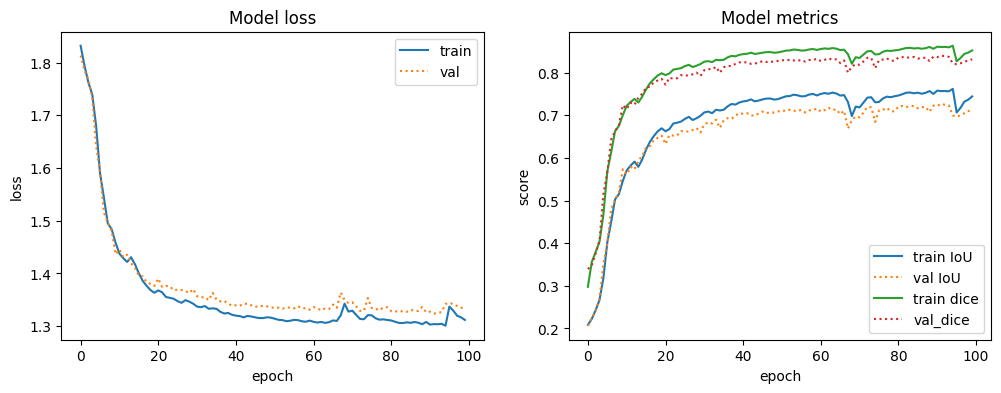

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(H['train_loss'])
plt.plot(H['test_loss'], linestyle='dotted')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(H['train_IoU'])
plt.plot(H['test_IoU'], linestyle='dotted')
plt.plot(H['train_DC'])
plt.plot(H['test_DC'], linestyle='dotted')
plt.title('Model metrics')
plt.ylabel('score')
plt.xlabel('epoch')

plt.legend(['train IoU', 'val IoU', 'train dice', 'val_dice'], loc='lower right')

plt.show()

In [15]:
def make_prediction(model, image):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		predMask = np.argmax(predMask, axis=-1)
		predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [16]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (0, 0, 0))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

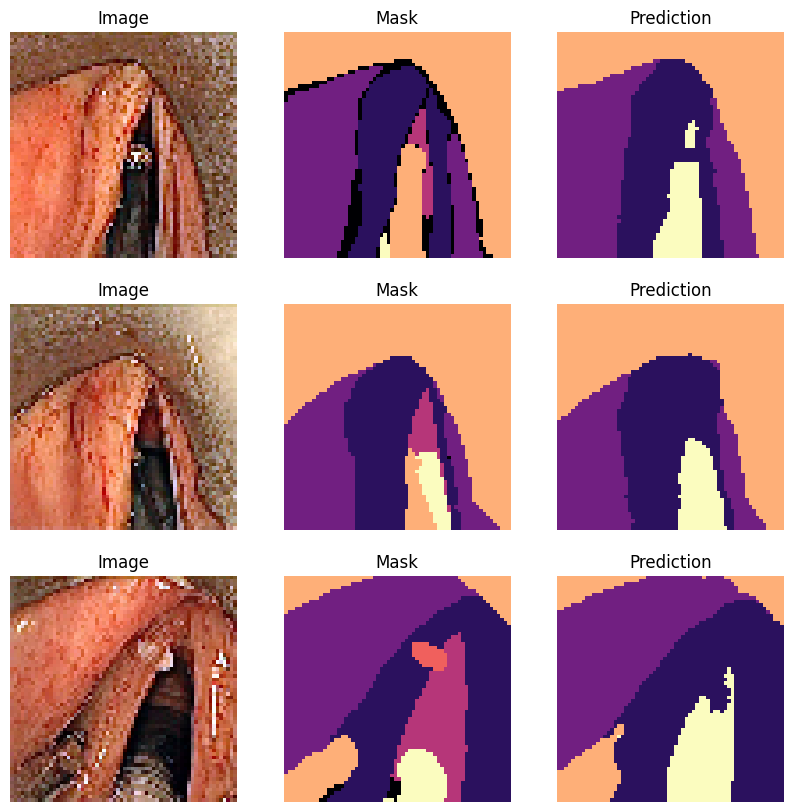

In [17]:
plt.figure(figsize=(10,10))
for i in range(3):    

    idx = random.randint(0, len(testImages) -1)
    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(331 + 3*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(332 + 3*i)
    plt.imshow(mask, cmap='magma', norm=plt.Normalize(vmin=0, vmax=NUM_CLASSES-1))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(333 + 3*i)
    plt.imshow(pred, cmap='magma', norm=plt.Normalize(vmin=0, vmax=NUM_CLASSES-1))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota